In [1]:
%load_ext autoreload
%autoreload 2

In [484]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2

from htools import *
from img_wang.data import MixupDataset, load_img, get_databunch
from incendio.callbacks import TorchCallback, MetricHistory
from incendio.core import Trainer
from incendio.layers import ConvBlock, ResBlock, mish, Mish

In [3]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [4]:
dir_u = Path('data/imagewang-160/unsup/')

In [440]:
bs = 2
dst, dsv, dlt, dlv = get_mixup_databunch(dir_u, bs=bs)

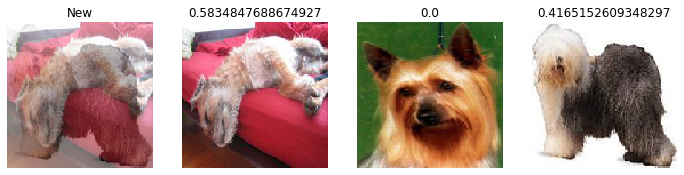

In [31]:
*imgs, w = dst[0]
show_images(imgs, figsize=(12, 4), titles=['New']+w.tolist())
plt.show()

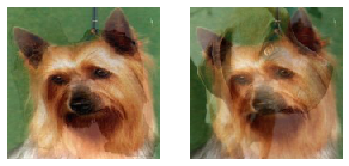

In [7]:
*xb, yb = next(iter(dlt))
show_images(xb[0])

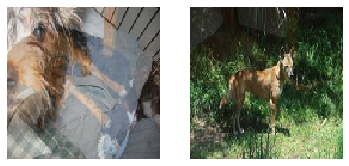

In [8]:
dst.shuffle()
*xb, yb = next(iter(dlt))
show_images(xb[0])

In [9]:
xb[0].shape

torch.Size([2, 3, 128, 128])

In [10]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

In [11]:
len(xb)

4

In [12]:
conv = nn.Conv2d(3, 5, 3)
fc = nn.AdaptiveAvgPool2d(1)
tmp = conv(xb[0])
tmp.shape

torch.Size([2, 5, 126, 126])

In [13]:
fc(tmp).squeeze().shape

torch.Size([2, 5])

torch.Size([8, 3, 128, 128])


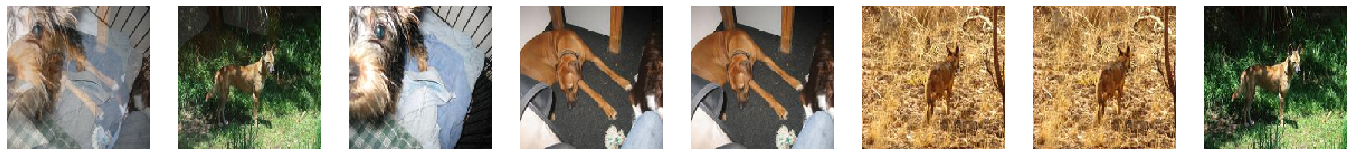

In [14]:
stk = torch.cat(xb, dim=0)
print(stk.shape)
show_images(stk)

In [15]:
tmp = conv(stk)
tmp.shape

torch.Size([8, 5, 126, 126])

In [16]:
bs = 2
shape = tmp.shape
tmp.view(bs, shape[1]*shape[0]//bs, *shape[-2:]).shape

torch.Size([2, 20, 126, 126])

In [39]:
class UnmixerModel(nn.Module):
    
    def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
                 padding=0, act=Mish(), res_blocks=0, temperature=1, 
                 **res_kwargs):
        super().__init__()
        if len(fs) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
                        activation=act, stride=stride, padding=padding) 
              for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
        )
        if res_blocks:
            self.res = nn.Sequential(*[ResBlock(c_in=fs[-1], **res_kwargs) 
                                       for _ in range(res_blocks)])
        self.pool = AdaptiveConcatPool2d(1)
        self.temp = temperature

    def forward(self, *xb):
        bs = xb[0].shape[0]
        # Stack along batch dimension so all images can be processed at once.
        xb = torch.cat(xb, dim=0)                    # (bs*(n+1), c, h, w)
        xb = self.conv(xb)                           # (bs*(n+1), f[-1], h, w)
        if hasattr(self, 'res'): xb = self.res(xb)   # No change in dims.
        xb = self.pool(xb).squeeze()                 # (bs*(n+1), emb_dim))
        xb = xb.view(bs, -1, xb.shape[-1])           # (bs, n+1, emb_dim)
        x_new, x_src = xb[:, 0, :], xb[:, 1:, :]
        xb = (x_new.unsqueeze(1) * x_src).sum(-1)    # (bs, n)
        return F.softmax(xb/self.temp, dim=-1)

In [418]:
AdaptiveConcatPool2d(1)(torch.randn(2, 3, 4, 4)).shape

torch.Size([2, 6, 1, 1])

In [502]:
# # Troubleshooting UnmixerModel. Take simpler approach by just encoding each x image separately.
# # Trying to figure out if my batching strategy is causing the failure to learn.
# class Encoder(nn.Module):
    
#     def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
#                  strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
#                  padding=0, act=Mish(), res_blocks=0, temperature=1, 
#                  **res_kwargs):
#         super().__init__()
#         if len(fs) != len(strides):
#             raise ValueError('Strides and f_dims must be same length (1 '
#                              ' value for each conv block).')
            
#         self.n = n
#         self.conv = nn.Sequential(
#             *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
#                         activation=act, stride=stride, padding=padding) 
#               for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
#         )
#         if res_blocks:
#             self.res = nn.Sequential(
#                 *[ResBlock(c_in=fs[-1], activation=act, **res_kwargs) 
#                   for _ in range(res_blocks)]
#             )
#         self.pool = AdaptiveConcatPool2d(1)
#         self.temp = temperature

#     def _forward(self, x):
#         x = self.conv(x)                             # (bs*(n+1), f[-1], h, w)
#         if hasattr(self, 'res'): x = self.res(x)     # No change in dims.
#         return self.pool(x).squeeze(-1).squeeze(-1)  # (bs*(n+1), emb_dim))
    
#     def forward(self, *xb):
#         x_new, *x = [self._forward(x) for x in xb]
#         x = torch.stack(x, dim=1)
#         print('forward', x_new.shape, x.shape)
#         x = (x_new.unsqueeze(1) * x).sum(-1)
#         return F.softmax(x/self.temp, dim=-1)
    
    
# Version of encoder that can be passed to Unmixer as the encoder arg.
class Encoder(nn.Module):
    
    def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
                 padding=0, act=Mish(), res_blocks=0, **res_kwargs):
        super().__init__()
        if len(fs) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
                        activation=act, stride=stride, padding=padding) 
              for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
        )
        if res_blocks:
            self.res = nn.Sequential(
                *[ResBlock(c_in=fs[-1], activation=act, **res_kwargs) 
                  for _ in range(res_blocks)]
            )

    def forward(self, x):
        x = self.conv(x)                             # (bs*(n+1), f[-1], h, w)
        if hasattr(self, 'res'): x = self.res(x)     # No change in dims.
        return x

In [402]:
tmp[:, None:, :1, :1].shape

torch.Size([2, 1280, 1, 1])

In [551]:
class Unmixer(nn.Module):
    
    @valuecheck
    def __init__(self, encoder, temperature=1.0, 
                 last_act:('sigmoid', 'softmax')='sigmoid'):
        super().__init__()
        self.encoder = encoder
        self.pool = AdaptiveConcatPool2d(1)
        self.last_act = torch.sigmoid if last_act == 'sigmoid' \
            else partial(F.softmax, dim=-1)
        self.temp = temperature
        
    def forward(self, *xb):
        x_new, *x = [self.pool(self.encoder(x)).squeeze(-1).squeeze(-1)
                     for x in xb]
        x = torch.stack(x, dim=1)
        x = (x_new[:, None, ...] * x).sum(-1)
        return self.last_act(x/self.temp)

In [341]:
xb[0][None, ..., None].squeeze(0).squeeze(-1).shape

torch.Size([2, 3, 128, 128])

In [210]:
enet = Encoder(fs=[16, 64], strides=[2, 1], res_blocks=2, temperature=64)
enet

Encoder(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
  )
  (res): Sequential(
    (0): ResBlock(
      (layers): ModuleList(
        (0): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [211]:
res = enet(*xb)

In [212]:
res.shape

torch.Size([2, 3])

In [213]:
res

tensor([[5.9190e-01, 3.8113e-01, 2.6965e-02],
        [2.5858e-04, 8.8602e-05, 9.9965e-01]], grad_fn=<SoftmaxBackward>)

In [178]:
%%timeit -n 25 -r 25
(res[0].unsqueeze(1) * res[1]).sum(-1)

The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
34.3 µs ± 16.8 µs per loop (mean ± std. dev. of 25 runs, 25 loops each)


In [179]:
%%timeit -n 25 -r 25
torch.bmm(res[0].unsqueeze(1), res[1].permute(0, 2, 1))

The slowest run took 42.03 times longer than the fastest. This could mean that an intermediate result is being cached.
68.6 µs ± 183 µs per loop (mean ± std. dev. of 25 runs, 25 loops each)


In [151]:
res[1].shape

torch.Size([2, 3, 512])

In [ ]:
(b×n×m) tensor, mat2 is a (b×m×p) tensor, out will be a(b×n×p) tensor.

In [80]:
net = UnmixerModel()
net

UnmixerModel(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [41]:
# # (bs, n+1, enc_dim)
# xn, xs = net(*xb)
# xn.shape, xs.shape

res = net(*xb)
res.shape

torch.Size([2, 3])

In [42]:
res

tensor([[0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000]], grad_fn=<SoftmaxBackward>)

In [43]:
resnet = UnmixerModel(res_blocks=3)
resnet

UnmixerModel(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [44]:
res = resnet(*xb)

In [45]:
res

tensor([[1.0000e+00, 5.3775e-37, 0.0000e+00],
        [5.0000e-01, 5.0000e-01, 0.0000e+00]], grad_fn=<SoftmaxBackward>)

In [120]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

In [128]:
F.mse_loss(res, yb, reduction='sum')

tensor(1.4579, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [130]:
(res - yb).pow(2).mean(1).sum(), (res - yb).pow(2).mean(1).mean(), (res - yb).pow(2).mean()

(tensor(0.4860, dtype=torch.float64, grad_fn=<SumBackward0>),
 tensor(0.2430, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2430, dtype=torch.float64, grad_fn=<MeanBackward0>))

In [46]:
class DatasetMixer(TorchCallback):
    
    def __init__(self, order=100):
        self.order = order
    
    def on_epoch_begin(self, trainer, epoch, val_stats):
        trainer.dl_train.dataset.shuffle()

## Test Tiny Trainer

In [562]:
paths_tiny = get_image_files(dir_u)[:12]
tdst, tdsv, tdlt, tdlv = get_mixup_databunch(paths=paths_tiny, train_pct=.5, 
                                             bs=2)
len(tdst), len(tdsv)

(4, 4)

In [563]:
for i, b in enumerate(tdlt):
    print(amap('shape', *b))

[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3])]
[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3])]


[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]


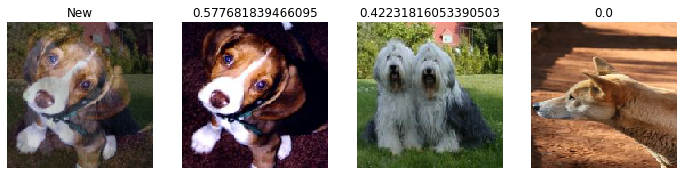

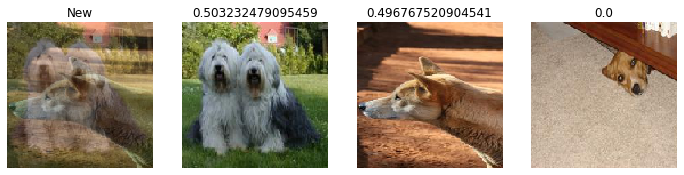

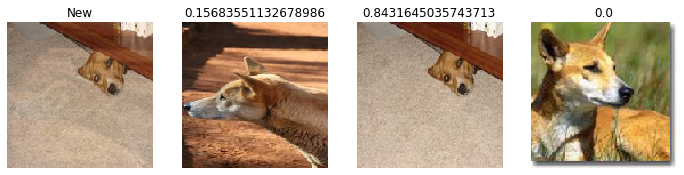

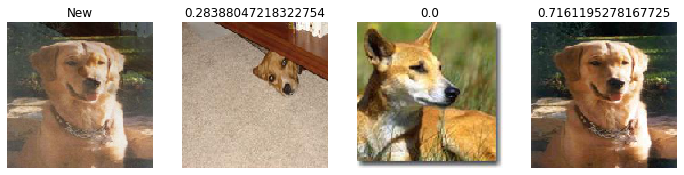

In [564]:
for i in range(len(tdst)):
    *x, y = tdst[i]
    print(amap('shape', *x))
    show_images(x, titles=['New']+y.tolist())

In [565]:
mnet = mobilenet_v2(pretrained=True)
mnet_enc = dict(mnet.named_children())['features']
mnet_unmix = Unmixer(mnet_enc, 1)

In [422]:
mnet_unmix(*xb)

stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


tensor([[0., 1., 0.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward>)

In [567]:
enet = Unmixer(Encoder(fs=[8, 32], strides=[1, 1]), temperature=32)
enet

Unmixer(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
    )
  )
  (pool): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
)

In [568]:
T = Trainer(enet, tdst, tdsv, tdlt, tdlv, F.mse_loss, mode='regression',
            out_dir='data/models/v0', 
            callbacks=[DatasetMixer(), MetricHistory()])

2020-08-09 17:45:52,272 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-09 17:45:53,684
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5289 |       0.1095 |

=====




2020-08-09 17:45:54,623
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5165 |       0.1189 |

=====




2020-08-09 17:45:56,843
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5138 |       0.2195 |

=====




2020-08-09 17:45:58,721
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5195 |       0.4223 |

=====




2020-08-09 17:45:59,926
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5062 |       0.5133 |

=====




2020-08-09 17:46:01,059
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5236 |       0.5231 |

=====




2020-08-09 17:46:02,879
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5098 |       0.5383 |

=====




2020-08-09 17:46:04,267
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5238 |       0.5336 |

=====




2020-08-09 17:46:05,846
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5258 |       0.5326 |

=====




2020-08-09 17:46:08,159
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5278 |       0.5105 |

=====

2020-08-09 17:46:08,174
 Training complete. Model in eval mode.


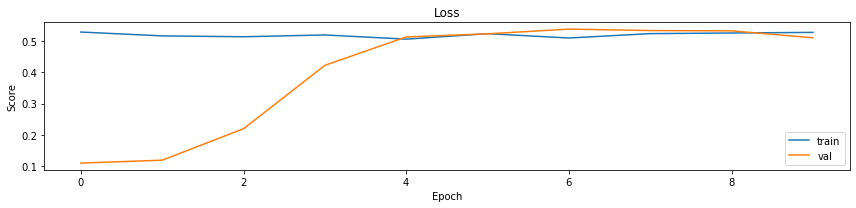

In [569]:
T.fit(10)

In [570]:
ls -lht data/models/v0

total 304
-rw-r--r--@ 1 hmamin  staff    13K Aug  9 17:46 history.png
-rw-r--r--  1 hmamin  staff   173B Aug  9 17:46 history.csv
-rw-r--r--  1 hmamin  staff    86K Aug  9 17:46 train.log


In [571]:
tdf = T.callbacks['MetricHistory'].df
tdf

,loss,val_loss
0,0.528879,0.109527
1,0.516542,0.118892
2,0.513811,0.219484
3,0.519522,0.422324
4,0.506173,0.513250
5,0.523645,0.523136
6,0.509757,0.538274
7,0.523799,0.533564
8,0.525779,0.532635
9,0.527783,0.510538


In [572]:
enet(*xb)

tensor([[1., 1., 1.],
        [1., 1., 1.]], grad_fn=<SigmoidBackward>)

## Scale Dataset Troubleshooting

In [495]:
paths_xtiny = get_image_files(dir_u)[:8]
sdst, sdsv, sdlt, sdlv = get_databunch(paths=paths_xtiny, mode='scale', bs=2, 
                                       train_pct=.5)

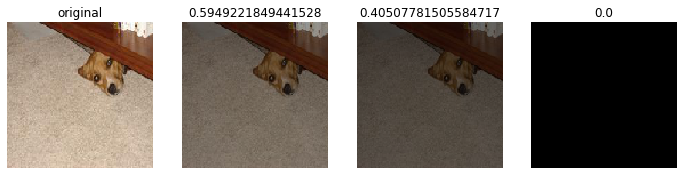

In [496]:
*x, y = sdst[0]
show_images(x, titles=['original']+y.tolist())

In [497]:
for *x, y in sdlv:
    print(amap('shape', *x), y.shape)

[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128])] torch.Size([2, 3])
[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128])] torch.Size([2, 3])


In [552]:
enet = Unmixer(Encoder(fs=[8, 32], strides=[1, 1]), temperature=32)
enet

Unmixer(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
    )
  )
  (pool): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
)

In [553]:
enet(*x)

tensor([[0.5000, 1.0000, 1.0000],
        [0.5000, 1.0000, 1.0000]], grad_fn=<SigmoidBackward>)

In [554]:
T = Trainer(enet, sdst, sdsv, sdlt, sdlv, F.mse_loss, mode='regression',
            out_dir='data/models/v0', callbacks=[MetricHistory()])


2020-08-09 17:37:46,172
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-09 17:37:47,526
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2956 |       0.2276 |

=====




2020-08-09 17:37:48,832
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2415 |       0.2020 |

=====




2020-08-09 17:37:49,978
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2410 |       0.2057 |

=====




2020-08-09 17:37:51,220
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2093 |       0.1858 |

=====




2020-08-09 17:37:52,914
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2172 |       0.1886 |

=====




2020-08-09 17:37:54,826
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2340 |       0.1922 |

=====




2020-08-09 17:37:56,437
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2360 |       0.2054 |

=====




2020-08-09 17:37:57,570
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1957 |       0.1899 |

=====




2020-08-09 17:37:59,851
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2236 |       0.1648 |

=====




2020-08-09 17:38:01,430
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2047 |       0.1743 |

=====

2020-08-09 17:38:01,434
 Training complete. Model in eval mode.


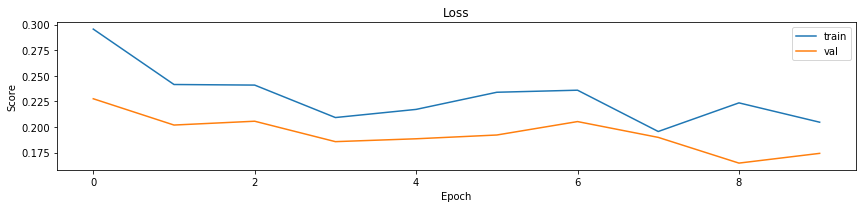

In [556]:
T.fit(10)

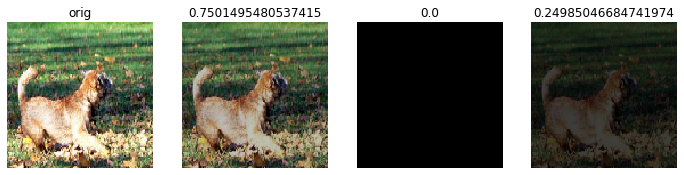

In [557]:
*x, y = next(iter(sdlt))
show_images([row[0] for row in x], titles=['orig']+y[0].tolist())

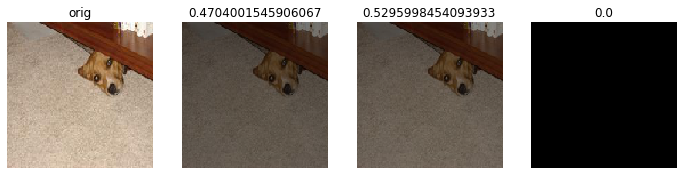

In [558]:
show_images([row[1] for row in x], titles=['orig']+y[1].tolist())

In [559]:
enet(*x)

tensor([[1.0000, 0.0983, 1.0000],
        [1.0000, 1.0000, 0.1788]], grad_fn=<SigmoidBackward>)

In [560]:
F.mse_loss(enet(*x), y)

tensor(0.1948, grad_fn=<MseLossBackward>)

In [561]:
y

tensor([[0.7501, 0.0000, 0.2499],
        [0.4704, 0.5296, 0.0000]])